In [1]:
import numpy as np
import pandas as pd

import re

In [51]:
bad_idx = []
with open('../test/logs/all_logs.log', 'r') as f:
    for line in f:
        m = re.search(r'\| WARNING \| .+ Got an exception while handling block with l_index of (\d+)\.$', line)
        if m:
            bad_idx.append(int(m.group(1)))

In [52]:
len(bad_idx)

5

In [2]:
df = pd.read_csv('../test/batches/batch_000.csv')
df

,frequency_index,frequency,kurtosis,snr,width,source file
0,94208,3151.200199,47.560604,1.770360,-0.000034,/home/andres/breakthrough-listen/data/blc40_gu...
1,94720,3151.198769,47.617520,1.769125,-0.000034,/home/andres/breakthrough-listen/data/blc40_gu...
2,201216,3150.901222,116.493190,55.186630,-0.000027,/home/andres/breakthrough-listen/data/blc40_gu...
3,201728,3150.899792,116.484160,54.346859,-0.000027,/home/andres/breakthrough-listen/data/blc40_gu...
4,203776,3150.894070,16.457384,4.432947,-0.000015,/home/andres/breakthrough-listen/data/blc40_gu...
...,...,...,...,...,...,...
853,64948736,2969.998741,19.276388,1.215248,-0.000005,/home/andres/breakthrough-listen/data/blc40_gu...
854,65535488,2968.359375,0.103830,0.344654,-0.000003,/home/andres/breakthrough-listen/data/blc40_gu...
855,65536000,2968.357944,0.076867,0.328818,-0.000005,/home/andres/breakthrough-listen/data/blc40_gu...
856,66584064,2965.429688,0.037342,0.306204,-0.000004,/home/andres/breakthrough-listen/data/blc40_gu...


In [54]:
bad_idx_mask = (df['frequency_index'].values.reshape((-1, 1)) == bad_idx).any(axis = 1)

In [55]:
bad_df = df[bad_idx_mask]

In [56]:
bad_df

,frequency_index,frequency,kurtosis,snr,width,source file
61,423424,3150.280380,234.66583,NaN,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
62,423936,3150.278950,234.69570,NaN,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
357,8441856,3127.877140,882.96140,NaN,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
513,18338816,3100.225353,834.46454,NaN,NaN,/home/andres/breakthrough-listen/data/blc40_gu...
782,45243904,3025.053406,134.40509,NaN,NaN,/home/andres/breakthrough-listen/data/blc40_gu...


In [6]:
import hdf5plugin
import h5py

f = h5py.File('/home/andres/breakthrough-listen/data/blc40_guppi_59358_40991_HIP3740_0031.rawspec.0000.h5')
data: h5py.Dataset = f['data'] #type: ignore

In [7]:
# l_idx = bad_df['frequency_index'].iloc[0]
l_idx = 423424

In [8]:
bad_data = data[:, 0, l_idx : l_idx+1024]

foff: float = data.attrs['foff'] #type: ignore
fch1: float = data.attrs['fch1'] #type: ignore
freq_array = np.linspace(
    fch1 + foff * l_idx,
    fch1 + foff * (l_idx + 1024),
    num=bad_data.shape[1]
) #type: ignore

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

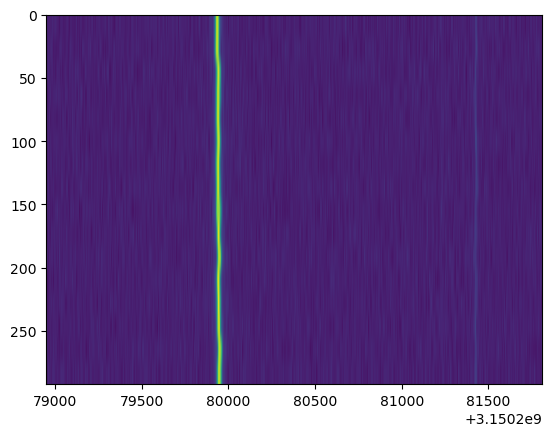

In [10]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.imshow(
    bad_data,
    extent=(
        freq_array[0] * 1e6, freq_array[-1] * 1e6,
        0, data.attrs['tsamp'] * bad_data.shape[0]
    ),
    aspect='auto',
    norm='log'
)
ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

In [13]:
y_vals = bad_data[6, :]

In [20]:
import scipy.optimize

def signal_model(x, mean, stdev, amp, noise):
    exponent = -0.5 * ((x - mean)/stdev)**2
    return noise + amp * np.exp(exponent)

params, cov = scipy.optimize.curve_fit(
    signal_model, freq_array, y_vals,
    p0=(
        freq_array[y_vals.argmax()],
        foff * -1,
        np.max(y_vals) - np.median(y_vals),
        np.median(y_vals)
    ),
    bounds=np.array([
        (freq_array[-1], freq_array[0]),
        (-np.inf, np.inf),
        (0, np.inf),
        (0, np.inf)
    ]).T
)
params, np.sqrt(np.diag(cov)) / params

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

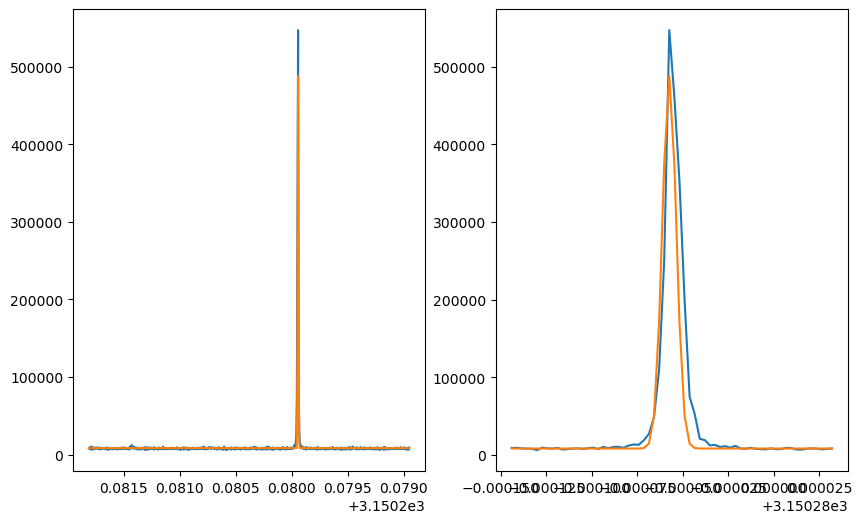

In [19]:
fig = plt.figure(figsize=(10, 6))

full_ax = fig.add_subplot(121)
full_ax.plot(freq_array, y_vals)
full_ax.plot(freq_array, signal_model(freq_array, *params))
full_ax.invert_xaxis()

max_arg = y_vals.argmax()
zoom_ax = fig.add_subplot(122)
zoom_ax.plot(freq_array[max_arg-32 : max_arg+32], y_vals[max_arg-32 : max_arg+32])
zoom_ax.plot(freq_array[max_arg-32 : max_arg+32], signal_model(freq_array, *params)[max_arg-32 : max_arg+32])

plt.show()